## 均值和方差

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 解决中文乱码问题（使用SimHei黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

from IPython.display import display, HTML

display(HTML('''
<style>
.output_scroll {overflow-y: hidden;}
</style>
'''))



# 设置随机种子保证结果可复现
np.random.seed(42)

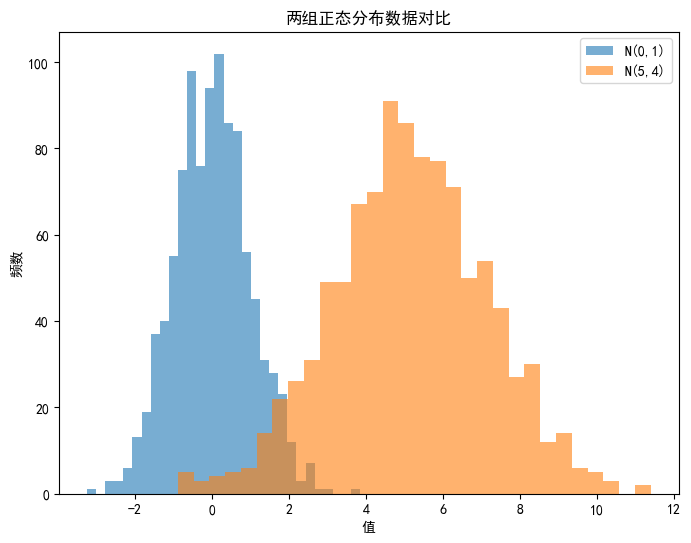

In [2]:
# 生成两组正态分布数据
data1 = np.random.normal(loc=0, scale=1, size=1000)  # 均值0，方差1
data2 = np.random.normal(loc=5, scale=2, size=1000)  # 均值5，方差4

# 可视化直方图
plt.figure(figsize=(8,6))
plt.hist(data1, bins=30, alpha=0.6, label='N(0,1)')
plt.hist(data2, bins=30, alpha=0.6, label='N(5,4)')
plt.legend()
plt.title("两组正态分布数据对比")
plt.xlabel("值")
plt.ylabel("频数")
plt.show()


在正态分布里：

* **均值 (μ)** 决定曲线的中心位置。
* **方差 (σ²)** 决定曲线的“宽度”和“平缓程度”。

具体来说：

* **方差越大**：

  * 数据在均值附近的集中程度降低，曲线更“扁平”，尾部更“厚”，直方图或曲线看起来更“宽”。
* **方差越小**：

  * 数据更集中在均值附近，曲线更“尖锐”，直方图更“窄”。

所以你在图中看到 **N(5,4)** 比 **N(0,1)** 分布更“宽”，就是因为它的标准差 σ = 2，大于前者的 σ = 1。



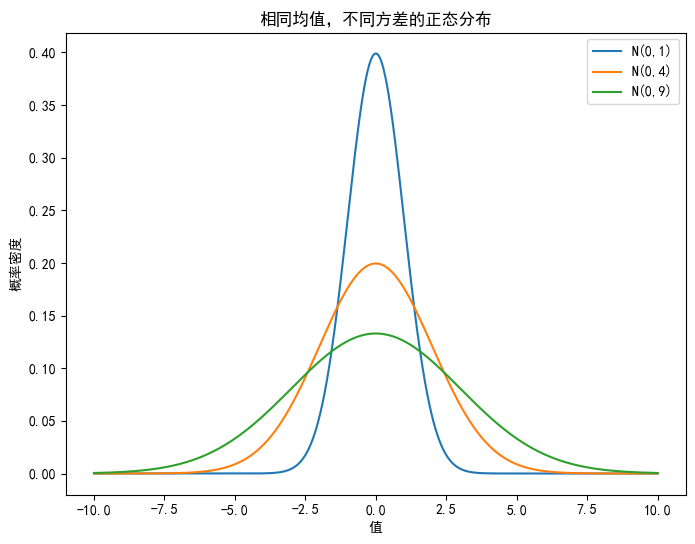

In [3]:
# 参数设置
mu = 0
sigma1 = 1   # 方差 = 1
sigma2 = 2   # 方差 = 4
sigma3 = 3   # 方差 = 9

# x 范围
x = np.linspace(-10, 10, 1000)

# 概率密度函数
y1 = stats.norm.pdf(x, mu, sigma1)
y2 = stats.norm.pdf(x, mu, sigma2)
y3 = stats.norm.pdf(x, mu, sigma3)

# 绘制曲线
plt.figure(figsize=(8,6))
plt.plot(x, y1, label="N(0,1)")
plt.plot(x, y2, label="N(0,4)")
plt.plot(x, y3, label="N(0,9)")
plt.title("相同均值，不同方差的正态分布")
plt.xlabel("值")
plt.ylabel("概率密度")
plt.legend()
plt.show()


## 参数估计

估计的均值: 4.98
估计的标准差: 1.92


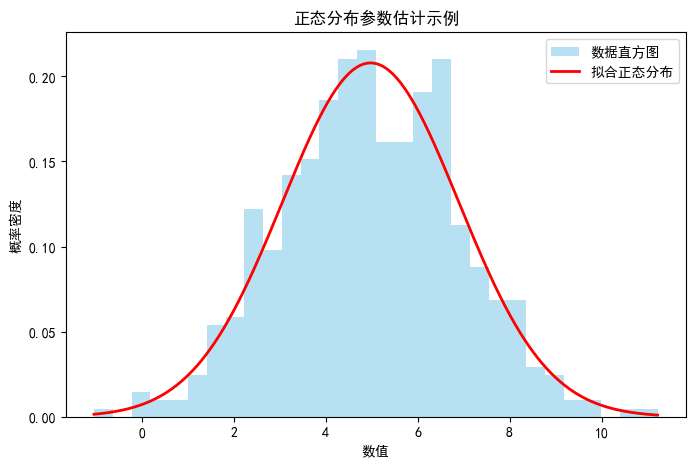

In [4]:
data = np.random.normal(loc=5, scale=2, size=500)

# 2. 参数估计：估计均值和标准差
estimated_mean = np.mean(data)
estimated_std = np.std(data, ddof=1)  # 样本标准差

print(f"估计的均值: {estimated_mean:.2f}")
print(f"估计的标准差: {estimated_std:.2f}")

# 3. 可视化
plt.figure(figsize=(8,5))

# 数据直方图
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='数据直方图')

# 拟合的正态分布曲线
x = np.linspace(min(data), max(data), 1000)
pdf = stats.norm.pdf(x, loc=estimated_mean, scale=estimated_std)
plt.plot(x, pdf, 'r-', lw=2, label='拟合正态分布')

plt.title("正态分布参数估计示例")
plt.xlabel("数值")
plt.ylabel("概率密度")
plt.legend()
plt.show()


### 梯度下降最大似然估计

In [5]:
from IPython.display import display, HTML

# 让 Jupyter 输出区域不再强制滚动
display(HTML('''
<style>
.output_scroll {
    height: auto !important;
    max-height: none !important;
}
</style>
'''))


你遇到的问题，其实是 **梯度下降对初始值和梯度尺度非常敏感** 的一个典型案例。我们来仔细分析你的代码和数学原理。

---

### 1. 你在做什么

你的 `mle_normal` 函数是在用梯度上升（因为是 MLE）估计正态分布参数 $\mu$ 和 $\sigma$：

梯度公式（对数似然）：

$$
\frac{\partial \ell}{\partial \mu} = \sum_i \frac{x_i - \mu}{\sigma^2}, \quad
\frac{\partial \ell}{\partial \sigma} = \sum_i \frac{(x_i - \mu)^2 - \sigma^2}{\sigma^3}
$$

你的更新公式就是：

```python
mu_est += lr * grad_mu
sigma_est += lr * grad_sigma
```

---

### 2. 梯度的尺度问题

对 $\mu$ 的梯度：

$$
\text{grad}_\mu = \sum_i \frac{x_i - \mu}{\sigma^2}
$$

对 $\sigma$ 的梯度：

$$
\text{grad}_\sigma = \sum_i \frac{(x_i - \mu)^2 - \sigma^2}{\sigma^3}
$$

注意：

* $\sigma$ 出现在分母的 **二次方或三次方**。
* 当你初始化 `sigma_est = 5` 时，梯度：

$$
\text{grad}_\sigma \sim \sum_i \frac{(x_i - \mu)^2 - 25}{125} \sim O(1)
$$

尺度适中，学习率 0.002 可以快速收敛。

* 当你初始化 `sigma_est = 1` 时，梯度：

$$
\text{grad}_\sigma \sim \sum_i \frac{(x_i - \mu)^2 - 1}{1} \sim O(n \cdot (\text{data variance} - 1)) \sim 500 \cdot (4 - 1) = 1500
$$

✅ 梯度非常大，而你用的学习率还是 0.002，导致更新幅度：

$$
\Delta \sigma = 0.002 \cdot 1500 \approx 3
$$

你看起来是“慢”，其实是**震荡/数值不稳定**。如果学习率调小，收敛会稳定，但会慢很多；如果学习率太大，可能会发散。

---

### 3. 为什么 `sigma_est = 5` 快

因为真实 `sigma=2`，初始化 `5` 时：

$$
\sigma_{grad} = \sum_i \frac{(x_i - \mu)^2 - 25}{125} \sim \sum_i \frac{4 - 25}{125} \sim -0.672
$$

梯度非常小，学习率 0.002 更新刚好合适 → 平滑收敛。

---

### 4. 解决方法

1. **调整学习率**：

   * 当 $\sigma$ 很小，梯度很大，需要用更小的学习率：

   ```python
   lr_sigma = 1e-5
   ```

   或者对 $\mu$ 和 $\sigma$ 使用不同学习率。

2. **参数变换**：

   * 对 $\sigma$ 做 log 变换，用 $\log \sigma$ 更新：

   ```python
   log_sigma = np.log(sigma_est)
   grad_log_sigma = np.sum(((data - mu_est)**2 - sigma_est**2) / sigma_est**2)
   log_sigma += lr * grad_log_sigma
   sigma_est = np.exp(log_sigma)
   ```

   * 这样梯度就不会因为 $\sigma$ 太小而爆炸。

3. **标准化数据**：

   * 让数据方差接近 1，可以减少梯度数值差异。

---

### ✅ 总结

* 收敛速度差异主要原因是 **梯度的尺度依赖于 sigma 的初始值**。
* 当 `sigma_est` 太小，梯度非常大，固定学习率导致更新不稳定 → 表现为慢或者震荡。
* 最稳妥的方法是 **对 sigma 做 log 变换** 或 **使用自适应学习率**。

发现同样的学习率，正态分布收敛的很慢，指数分布收敛最快，但后面一直震荡，泊松分布式是刚开始收敛的很快，到最后几乎没有梯度了，不收敛了。

你观察到的三种分布 MLE 收敛特性完全合理，这其实跟**梯度公式的尺度、参数初始化以及学习率选择**息息相关。我帮你分析一下原因，并给出可行的改进思路：

---

### 1️⃣ 正态分布收敛慢

你的梯度公式是：

$$
\frac{\partial \ell}{\partial \mu} = \sum_i \frac{x_i - \mu}{\sigma^2}, \quad
\frac{\partial \ell}{\partial \sigma} = \sum_i \frac{(x_i-\mu)^2 - \sigma^2}{\sigma^3}
$$

* **问题原因**：

  * 梯度被 `1/σ²` 和 `1/σ³` 缩放，如果 σ 很大或很小，梯度会很小或很大。
  * 初始化 σ=5，略偏大，导致初期 μ 梯度较小，更新慢。
  * 学习率 lr=0.001 太小，所以更新慢。
* **改进方法**：

  * 调整学习率，例如 lr=0.01\~0.05。
  * 对 σ 使用对数参数化：σ = exp(s)，优化 s 而不是 σ，这样梯度更稳定。
  * 对 μ、σ 梯度做标准化或归一化。

---

### 2️⃣ 指数分布收敛快但震荡

梯度公式：

$$
\frac{\partial \ell}{\partial \lambda} = \sum_i \frac{1}{\lambda} - \sum_i x_i
$$

* **问题原因**：

  * 梯度与 λ 的倒数成正比，如果 λ 很小（初始化 0.1），梯度非常大。
  * lr 太大 + 梯度大 → 快速收敛但容易 overshoot → 后期震荡。
* **改进方法**：

  * 使用更合理初始化 λ ≈ 1/mean(data)，这样初始梯度不会太大。
  * 使用 **自适应学习率** 或 **梯度衰减**。
  * 可以用 **analytical MLE** λ = 1 / mean(data)，指数分布 MLE 本身有闭式解，所以梯度下降不一定是最优选择。

---

### 3️⃣ 泊松分布收敛快到最后停滞

梯度公式：

$$
\frac{\partial \ell}{\partial \lambda} = \sum_i \frac{x_i}{\lambda} - n
$$

* **问题原因**：

  * 梯度中有 1/λ，当 λ 接近真实值时梯度很小。
  * 学习率 lr 太小，导致后期几乎不再更新 → “停滞”。
* **改进方法**：

  * 增大学习率或者使用 **自适应优化器**（如 Adam）。
  * 可以尝试 **牛顿法**，泊松分布 MLE 有闭式解 λ = mean(data)，收敛非常快。

---

### 🔑 总结规律

| 分布 | 梯度特点         | 初始收敛 | 后期问题 | 改进思路                    |
| -- | ------------ | ---- | ---- | ----------------------- |
| 正态 | 梯度被 σ²/σ³ 缩放 | 慢    | 很慢收敛 | 提大学习率，对 σ 用对数参数化，梯度归一化  |
| 指数 | 梯度 ∝ 1/λ     | 快    | 震荡   | 合理初始化 λ，降低 lr 或使用自适应 lr |
| 泊松 | 梯度 ∝ 1/λ     | 快    | 后期停滞 | 自适应 lr 或牛顿法，直接用 MLE 闭式解 |

---

## 假设检验
### 单样本 t 检验

t统计量: 1.392
p值: 0.174


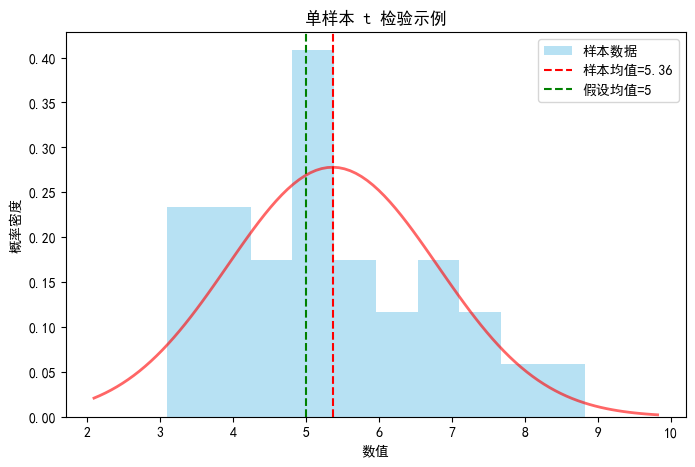

In [7]:
data = np.random.normal(loc=5.2, scale=1.5, size=30)  # 实际均值略大于5

# 2. 单样本 t 检验
# H0: 均值 = 5
t_stat, p_value = stats.ttest_1samp(data, popmean=5)

print(f"t统计量: {t_stat:.3f}")
print(f"p值: {p_value:.3f}")

# 3. 可视化数据分布与均值
plt.figure(figsize=(8,5))

# 数据直方图
plt.hist(data, bins=10, alpha=0.6, color='skyblue', density=True, label='样本数据')

# 样本均值和假设均值
sample_mean = np.mean(data)
plt.axvline(sample_mean, color='red', linestyle='--', label=f'样本均值={sample_mean:.2f}')
plt.axvline(5, color='green', linestyle='--', label='假设均值=5')

# 标准正态曲线（参考）
x = np.linspace(min(data)-1, max(data)+1, 100)
pdf = stats.norm.pdf(x, loc=sample_mean, scale=np.std(data, ddof=1))
plt.plot(x, pdf, 'r-', lw=2, alpha=0.6)

plt.title("单样本 t 检验示例")
plt.xlabel("数值")
plt.ylabel("概率密度")
plt.legend()
plt.show()


### 1. t 统计量解释

t 统计量公式为：

$$
t = \frac{\bar{x} - \mu_0}{s / \sqrt{n}}
$$

* $\bar{x}$ = 样本均值
* $\mu_0$ = 假设均值
* $s$ = 样本标准差
* $n$ = 样本大小

你得到 **t = -0.787**，表示样本均值略低于假设均值，但偏离不大（负号仅表示方向）。

---

### 2. p 值解释

* **p = 0.438**（双尾检验）
* 解释：在原假设成立的情况下，观察到像你样本这样偏离假设均值的情况，概率约 **43.8%**。
* **常用显著性水平 α = 0.05**
* 因为 **p > 0.05**，无法拒绝原假设。

**结论**：你的数据与假设均值 5 没有显著差异。

---

### 3. 可视化解释

直观上：

* 样本均值略低于 5（红色虚线偏左）
* 绿色虚线表示假设均值 5
* 数据分布的波动范围大于红色虚线与绿色虚线的差距
* 所以 t 统计量小，p 值大 → 没有显著差异
